### Importing required libraries

In [65]:
# importing required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
import os
import requests
import IPython.display as display
import PIL.Image

### Downloading, loading and displaying Content and Style Images

In [66]:
# downloading content and style images
def download_img(url, dest_path):
  with open(dest_path, 'wb') as f :
    response = requests.get(url)
    f.write(response.content)

content_img_url  = 'https://github.com/vasugupta9/DeepLearningProjects/blob/main/NeuralStyleTransfer/content.jpg?raw=true'
content_imgpath  = '/content/content_img.jpg'
style_img_url    = 'https://github.com/vasugupta9/DeepLearningProjects/blob/main/NeuralStyleTransfer/style_mosaic.jpg?raw=true'
style_imgpath    = '/content/style_img.jpg'

download_img(content_img_url, content_imgpath)
download_img(style_img_url, style_imgpath)


Resolution content_img: (520, 1050, 3), style_img: (391, 470, 3)
Range of values in content image: 0.0 - 1.0 , range of values in style image: 0.0 - 1.0


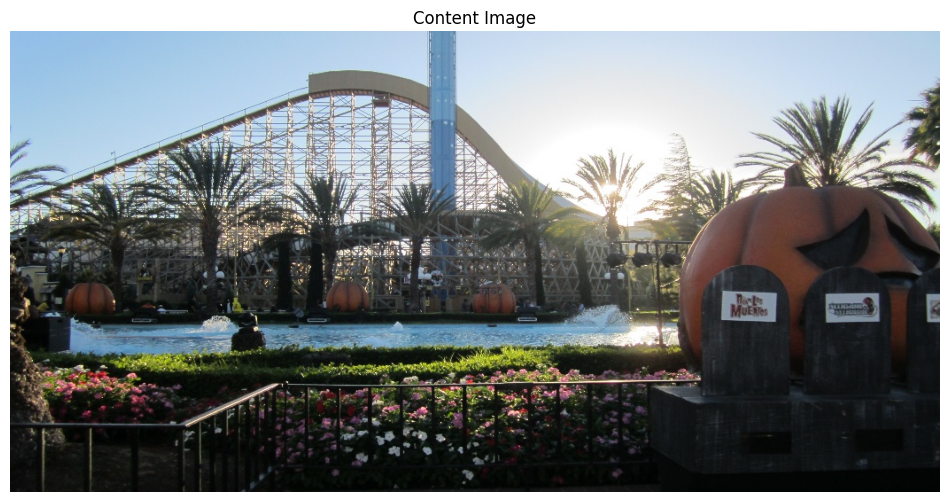

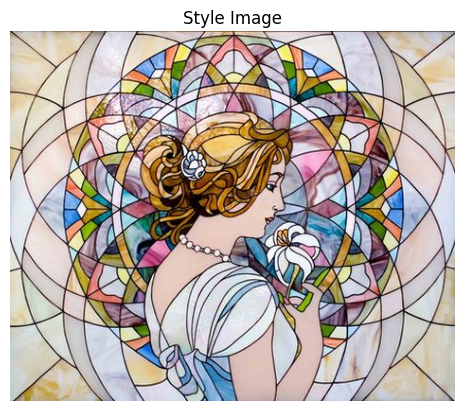

In [67]:
# reading and displaying content and style images
content_img = cv2.imread(content_imgpath)
content_img = cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB) # converting from BGR to RGB(Red-Green-Blue) format since cv2 loads images in BGR format
content_img = content_img/255. # normalizing to have values in the range 0-1

style_img   = cv2.imread(style_imgpath)
style_img   = cv2.cvtColor(style_img, cv2.COLOR_BGR2RGB) # converting from BGR to RGB(Red-Green-Blue) format since cv2 loads images in BGR format
style_img   = style_img/255. # normalizing to have values in the range 0-1

print(f"Resolution content_img: {content_img.shape}, style_img: {style_img.shape}")
print(f"Range of values in content image: {np.min(content_img)} - {np.max(content_img)} , range of values in style image: {np.min(style_img)} - {np.max(style_img)}")

# visualizing content and style images
plt.figure(figsize=(12,8))
plt.imshow(content_img)
plt.title('Content Image')
plt.axis('off')

plt.figure()
plt.imshow(style_img)
plt.title('Style Image')
plt.axis('off')
plt.show()


### Loading pre-trained VGG19 model, selecting inner layers for extracting content and style of an image, defining a model for getting these outputs

In [68]:
# loading pretrained Xception model
base_model_vgg = tf.keras.applications.Xception(include_top=False , weights='imagenet')
base_model_vgg.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_4[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, None, None, 32)       0         ['block1_conv1_bn[0][0]

In [69]:
# selecting layers (by name included in model summary) for extracting the content and style of an image
# inner layers other than the ones selected are also potential choices for extracting content and style

style_layer_names = [
    'input_1',
    'block1_conv1', 'block1_conv1_bn', 'block1_conv1_act',
    'block1_conv2', 'block1_conv2_bn', 'block1_conv2_act',
    'block2_sepconv1', 'block2_sepconv1_bn', 'block2_sepconv2_act',
    'block2_sepconv2', 'block2_sepconv2_bn', 'conv2d', 'block2_pool',
    'batch_normalization', 'add', 'block3_sepconv1_act',
    'block3_sepconv1', 'block3_sepconv1_bn', 'block3_sepconv2_act',
    'block3_sepconv2', 'block3_sepconv2_bn', 'conv2d_1', 'block3_pool',
    'batch_normalization_1', 'add_1', 'block4_sepconv1_act',
    'block4_sepconv1', 'block4_sepconv1_bn', 'block4_sepconv2_act',
    'block4_sepconv2', 'block4_sepconv2_bn', 'conv2d_2', 'block4_pool',
    'batch_normalization_2', 'add_2', 'block5_sepconv1_act',
    'block5_sepconv1', 'block5_sepconv1_bn', 'block5_sepconv2_act',
    'block5_sepconv2', 'block5_sepconv2_bn', 'conv2d_3', 'block5_pool',
    'batch_normalization_3', 'add_3', 'block6_sepconv1_act',
    'block6_sepconv1', 'block6_sepconv1_bn', 'block6_sepconv2_act',
    'block6_sepconv2', 'block6_sepconv2_bn', 'conv2d_4', 'block6_pool',
    'batch_normalization_4', 'add_4', 'block7_sepconv1_act',
    'block7_sepconv1', 'block7_sepconv1_bn', 'block7_sepconv2_act',
    'block7_sepconv2', 'block7_sepconv2_bn', 'conv2d_5', 'block7_pool',
    'batch_normalization_5', 'add_5', 'block8_sepconv1_act',
    'block8_sepconv1', 'block8_sepconv1_bn', 'block8_sepconv2_act',
    'block8_sepconv2', 'block8_sepconv2_bn', 'conv2d_6', 'block8_pool',
    'batch_normalization_6', 'add_6', 'block9_sepconv1_act',
    'block9_sepconv1', 'block9_sepconv1_bn', 'block9_sepconv2_act',
    'block9_sepconv2', 'block9_sepconv2_bn', 'conv2d_7', 'block9_pool',
    'batch_normalization_7', 'add_7', 'block10_sepconv1_act',
    'block10_sepconv1', 'block10_sepconv1_bn', 'block10_sepconv2_act',
    'block10_sepconv2', 'block10_sepconv2_bn', 'conv2d_8', 'block10_pool',
    'batch_normalization_8', 'add_8', 'block11_sepconv1_act',
    'block11_sepconv1', 'block11_sepconv1_bn', 'block11_sepconv2_act',
    'block11_sepconv2', 'block11_sepconv2_bn', 'conv2d_9', 'block11_pool',
    'batch_normalization_9', 'add_9', 'block12_sepconv1_act',
    'block12_sepconv1', 'block12_sepconv1_bn', 'block12_sepconv2_act',
    'block12_sepconv2', 'block12_sepconv2_bn', 'conv2d_10', 'block12_pool',
    'batch_normalization_10', 'add_10', 'block13_sepconv1_act',
    'block13_sepconv1', 'block13_sepconv1_bn', 'block13_sepconv2_act',
    'block13_sepconv2', 'block13_sepconv2_bn', 'conv2d_11', 'block13_pool',
    'batch_normalization_11', 'add_11', 'block14_sepconv1_act',
    'block14_sepconv1', 'block14_sepconv1_bn', 'block14_sepconv2_act',
    'block14_sepconv2', 'block14_sepconv2_bn', 'conv2d_12', 'block14_pool',
    'batch_normalization_12', 'add_12', 'block15_sepconv1_act',
    'block15_sepconv1', 'block15_sepconv1_bn', 'block15_sepconv2_act',
    'block15_sepconv2', 'block15_sepconv2_bn', 'conv2d_13', 'block15_pool',
    'batch_normalization_13', 'add_13', 'block16_sepconv1_act',
    'block16_sepconv1', 'block16_sepconv1_bn', 'block16_sepconv2_act',
    'block16_sepconv2', 'block16_sepconv2_bn', 'conv2d_14', 'block16_pool',
    'batch_normalization_14', 'add_14', 'block14_sepconv3',
    'block14_sepconv3_bn', 'block14_sepconv3_act', 'block15_sepconv3',
    'block15_sepconv3_bn', 'block15_sepconv3_act', 'block16_sepconv3',
    'block16_sepconv3_bn', 'block16_sepconv3_act',
]



num_style_layers    = len(style_layer_names)

content_layer_name  = ['block5_conv2']
assert (len(content_layer_name) == 1) , 'code assumes only 1 content layer is used'

print("Number of style layers used: {}".format(num_style_layers))


Number of style layers used: 165


### Defining functions for computing gram matrix, function for extracting image style and content, function for computing loss

In [70]:
# defining function for computing the Gram Matrix
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape   = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32) # total number of i,j pixel locations . computing for normalizing the result
  return result/num_locations


In [71]:
# defining function for extracting image style and content
# img_tensor - input image tensor for which style and content features are calculated
# mode_layer_outputs - model for extracting style and content outputs .
def extract_style_content(img_tensor, model) :
  preprocessed_img = tf.keras.applications.vgg19.preprocess_input(img_tensor*255.) # preprocessing specific to vgg19 model. Multiplying by 255. since preprocess function expects float inputs in range 0-255.
  outputs = model(preprocessed_img)
  content_output = outputs[-1] # selecting last output and
  style_outputs  = outputs[:-1] # a list of style layer outputs
  style_outputs  = [gram_matrix(style_output) for style_output in style_outputs] # extracting style for each style layer using Gram matrix
  return style_outputs, content_output


In [72]:
# defining the loss function
# target_style_outputs refers to style outputs of the style image
# target_content_output refers to content output of the content_image
def custom_loss(style_outputs, content_output, target_style_outputs, target_content_output) :
  style_weight = 1e-2  # tunable hyperparameter
  content_weight = 1e4 # tunable hyperparameter

  style_layer_losses = [ tf.reduce_mean((output - target_output)**2) for output, target_output in zip(style_outputs, target_style_outputs)  ]
  style_loss = tf.add_n(style_layer_losses)/len(style_layer_losses)

  content_loss = tf.reduce_mean( (content_output - target_content_output)**2  )

  total_loss = style_weight*style_loss + content_weight*content_loss
  return total_loss


### Setting up training parameters, optimizer, helper functions, etc

In [73]:
# initializing various parameters

# computing target content and style outputs
content_img_tensor = tf.expand_dims(tf.constant(content_img),axis=0)
_ , target_content_output = extract_style_content( content_img_tensor , model) # selecting content of content image

style_img_tensor = tf.expand_dims(tf.constant(style_img),axis=0)
target_style_outputs, _ = extract_style_content( style_img_tensor , model) # selecting style of style image


In [74]:
# defining the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

In [75]:
# defining a function to clip the pixel values to the range 0-1 (used during training)
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [76]:
# defining function for converting from tensor to image (for using during visualization of the generated image)
def tensor_to_image(tensor):
  tensor = tensor*255
  arr = np.array(tensor, dtype=np.uint8)
  arr = arr[0]
  return PIL.Image.fromarray(arr)

In [77]:
# defining function for single step through the training loop
@tf.function()
def train_step(img, model, optimizer, target_style_outputs, target_content_output):

  with tf.GradientTape() as tape :
    style_outputs, content_output = extract_style_content(img, model)
    loss = custom_loss(style_outputs, content_output, target_style_outputs, target_content_output)

  grad = tape.gradient(loss, img)
  optimizer.apply_gradients([(grad,img)])
  img.assign(clip_0_1(img))


img shape: (1, 520, 1050, 3)


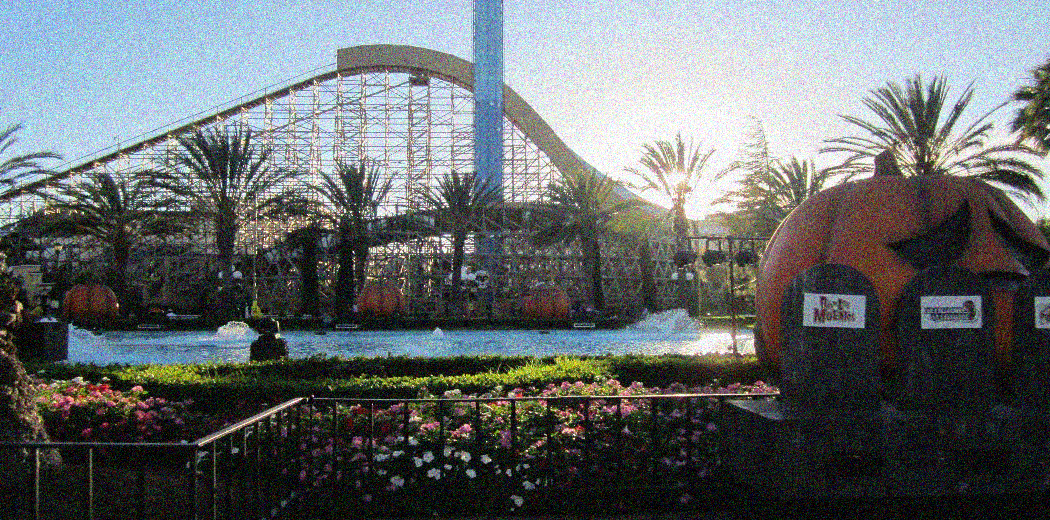

In [78]:
# initializing the input image which will be updated during training and is the same as the generated style-transferred image
img = content_img.copy() + 0.1*np.random.randn(*content_img.shape) # initializing generated image to be same as content image + added random noise
img = np.clip(img, 0. , 1.)
img = np.expand_dims(img, axis=0)
print(f"img shape: {img.shape}")

img = tf.Variable(img) # converting to tensorflow variable

# visualizing initial image
display.display(tensor_to_image(img))


### Training the model for style transfer

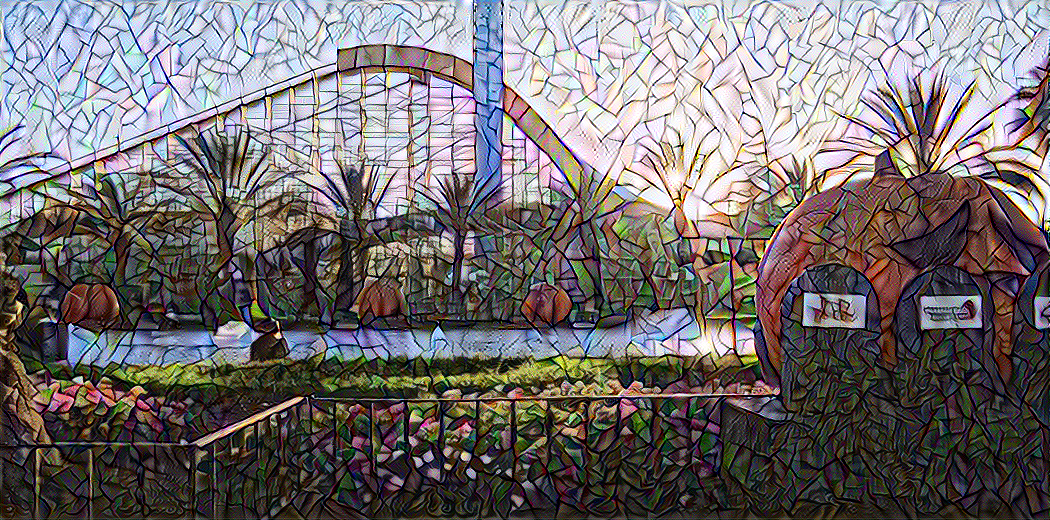

Train step: 200
Total training time: 41.2 seconds


In [62]:
# defining the training loop
num_epochs = 2
steps_per_epoch = 100
step = 0

start = time.time()
for n in range(num_epochs) :
  for m in range(steps_per_epoch):
    step = step + 1
    train_step(img, model, optimizer, target_style_outputs, target_content_output)
    print(".",end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(img))
  print("Train step: {}".format(step))
end = time.time()

print("Total training time: {:.1f} seconds".format(end-start))

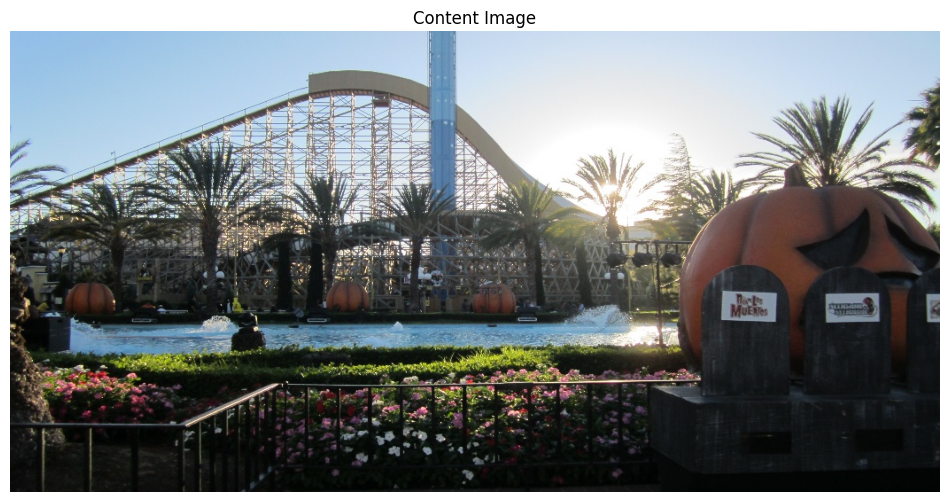

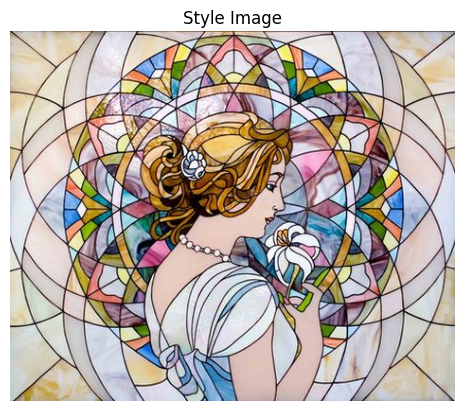

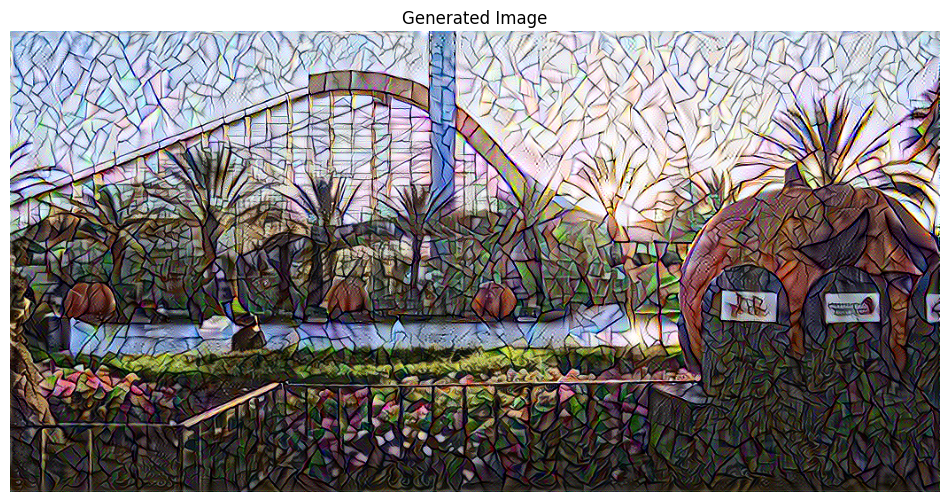

In [63]:
# displaying content, style and generated style transferred images

plt.figure(figsize=(12,8))
plt.imshow(content_img)
plt.title('Content Image')
plt.axis('off')

plt.figure()
plt.imshow(style_img)
plt.title('Style Image')
plt.axis('off')

plt.figure(figsize=(12,8))
generated_img = np.array(tensor_to_image(img))
plt.imshow(generated_img)
plt.title('Generated Image')
plt.axis('off')

plt.show()

In [64]:
# code for saving generated image as .jpg format image file
generated_imgpath = 'generated_img.jpg'
generated_img_bgr = cv2.cvtColor(generated_img, cv2.COLOR_RGB2BGR) # converting to BGR format for saving using opencv
cv2.imwrite(generated_imgpath, generated_img_bgr)

True